In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [2]:
# paths and basic params
train_dir = r"C:\Users\USER\OneDrive\Desktop\scene_classification\seg_train\seg_train"
test_dir  = r"C:\Users\USER\OneDrive\Desktop\scene_classification\seg_test\seg_test"
pred_dir  = r"C:\Users\USER\OneDrive\Desktop\scene_classification\seg_pred\seg_pred"  

IMG_HEIGHT, IMG_WIDTH = 150, 150  
BATCH_SIZE = 32
EPOCHS = 15


In [3]:
# data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",   #  categorical -> one-hot labels
    shuffle=True
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",   # keep same mode for evaluation
    shuffle=False               # keep False so predictions align with test_data.classes
)

# Useful debug prints
class_labels = list(train_data.class_indices.keys())
NUM_CLASSES = len(class_labels)
print("Classes (labels):", class_labels)
print("Number training images:", train_data.samples)
print("Number test images:", test_data.samples)
print("NUM_CLASSES:", NUM_CLASSES)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Classes (labels): ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number training images: 14034
Number test images: 3000
NUM_CLASSES: 6


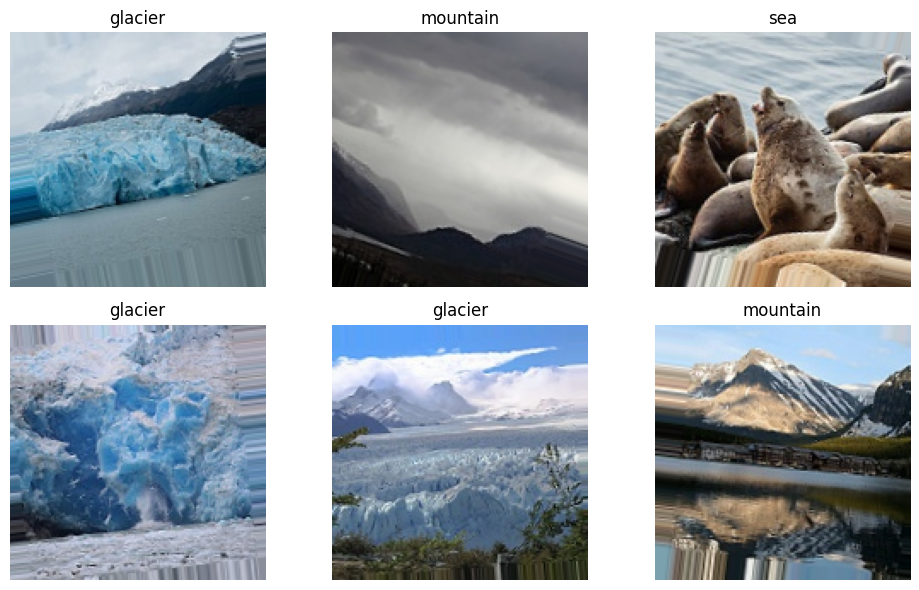

In [4]:
# show sample images
x_batch, y_batch = next(train_data)
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(class_labels[np.argmax(y_batch[i])])
    plt.axis("off")
plt.tight_layout()


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Get number of classes from your dataset
num_classes = train_data.num_classes
print("Number of scene categories:", num_classes)

# Build model
model = Sequential([
    Input(shape=(150, 150, 3)),  
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")   # multi-class output
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


Number of scene categories: 6


In [7]:
print("Class indices:", train_data.class_indices)   # dictionary mapping
print("Number of classes:", len(train_data.class_indices))


Class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Number of classes: 6


In [8]:
# callbacks + train
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_scene_model.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=test_data,
    callbacks=callbacks
)


C:\Users\USER\anaconda3_2\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.4539 - loss: 1.3985

439/439 ━━━━━━━━━━━━━━━━━━━━ 390s 874ms/step - accuracy: 0.4541 - loss: 1.3981 - val_accuracy: 0.6380 - val_loss: 0.9419
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.6292 - loss: 0.9757

439/439 ━━━━━━━━━━━━━━━━━━━━ 400s 909ms/step - accuracy: 0.6293 - loss: 0.9756 - val_accuracy: 0.7053 - val_loss: 0.8199
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.6847 - loss: 0.8517

439/439 ━━━━━━━━━━━━━━━━━━━━ 354s 805ms/step - accuracy: 0.6848 - loss: 0.8516 - val_accuracy: 0.7617 - val_loss: 0.6440
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.7319 - loss: 0.7505

439/439 ━━━━━━━━━━━━━━━━━━━━ 352s 802ms/step - accuracy: 0.7320 - loss: 0.7504 - val_accuracy: 0.8063 - val_loss: 0.5457
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.7467 - loss: 0.7155

439/439 ━━━━━━━━━━━━━━━━━━━━ 360s 818ms/step - accuracy: 0.7467 - loss: 0.7154 - val_accuracy: 0.8140 - val_loss: 0.5413
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.7742 - loss: 0.6285

439/439 ━━━━━━━━━━━━━━━━━━━━ 359s 816ms/step - accuracy: 0.7742 - loss: 0.6285 - val_accuracy: 0.8340 - val_loss: 0.4750
Epoch 7/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 372s 793ms/step - accuracy: 0.7867 - loss: 0.6167 - val_accuracy: 0.8270 - val_loss: 0.5120
Epoch 8/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.7879 - loss: 0.5916

439/439 ━━━━━━━━━━━━━━━━━━━━ 354s 806ms/step - accuracy: 0.7879 - loss: 0.5916 - val_accuracy: 0.8373 - val_loss: 0.4716
Epoch 9/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.7980 - loss: 0.5718

439/439 ━━━━━━━━━━━━━━━━━━━━ 356s 810ms/step - accuracy: 0.7980 - loss: 0.5718 - val_accuracy: 0.8460 - val_loss: 0.4438
Epoch 10/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.8058 - loss: 0.5650

439/439 ━━━━━━━━━━━━━━━━━━━━ 360s 819ms/step - accuracy: 0.8058 - loss: 0.5649 - val_accuracy: 0.8493 - val_loss: 0.4437
Epoch 11/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.8152 - loss: 0.5396

439/439 ━━━━━━━━━━━━━━━━━━━━ 364s 829ms/step - accuracy: 0.8152 - loss: 0.5396 - val_accuracy: 0.8503 - val_loss: 0.4405
Epoch 12/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8101 - loss: 0.5375

439/439 ━━━━━━━━━━━━━━━━━━━━ 359s 817ms/step - accuracy: 0.8101 - loss: 0.5375 - val_accuracy: 0.8590 - val_loss: 0.4208
Epoch 13/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.8110 - loss: 0.5358

439/439 ━━━━━━━━━━━━━━━━━━━━ 357s 814ms/step - accuracy: 0.8110 - loss: 0.5358 - val_accuracy: 0.8587 - val_loss: 0.4115
Epoch 14/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 357s 812ms/step - accuracy: 0.8279 - loss: 0.4924 - val_accuracy: 0.8510 - val_loss: 0.4306
Epoch 15/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 357s 813ms/step - accuracy: 0.8252 - loss: 0.4966 - val_accuracy: 0.8430 - val_loss: 0.4661


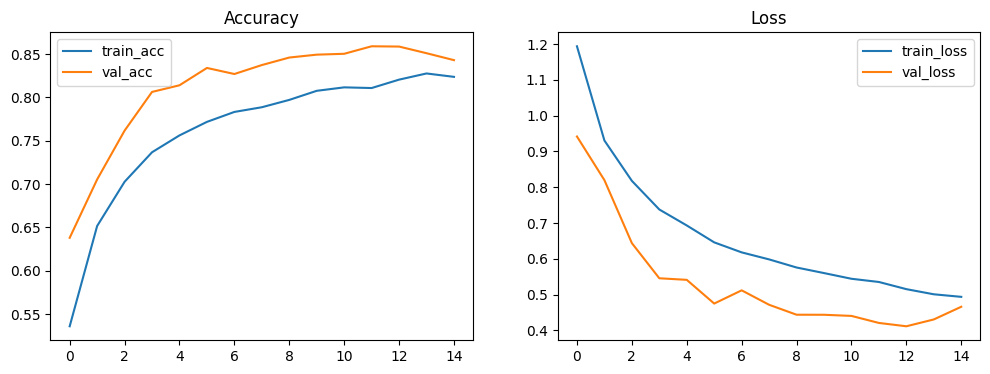

In [9]:
# plot curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - accuracy: 0.8647 - loss: 0.3883
Test accuracy: 85.87% — Test loss: 0.4115
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step


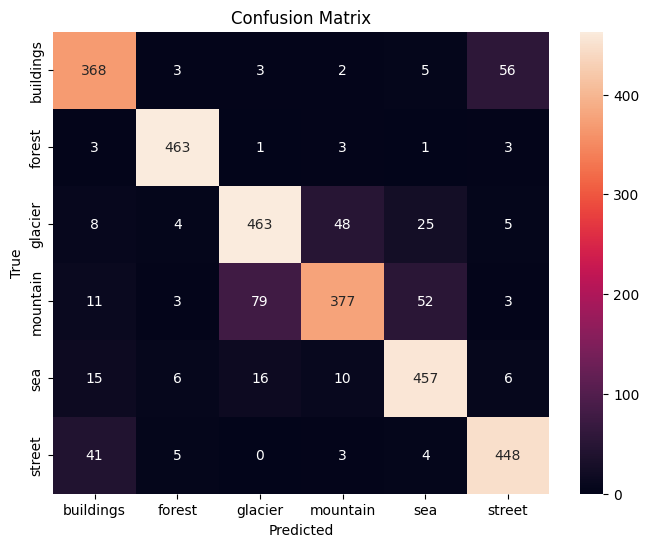

Classification Report:
              precision    recall  f1-score   support

   buildings     0.8251    0.8421    0.8335       437
      forest     0.9566    0.9768    0.9666       474
     glacier     0.8238    0.8373    0.8305       553
    mountain     0.8510    0.7181    0.7789       525
         sea     0.8401    0.8961    0.8672       510
      street     0.8599    0.8942    0.8767       501

    accuracy                         0.8587      3000
   macro avg     0.8594    0.8608    0.8589      3000
weighted avg     0.8585    0.8587    0.8574      3000



In [11]:
# evaluate & predictions
test_loss, test_acc = model.evaluate(test_data, verbose=1)
print(f"Test accuracy: {test_acc*100:.2f}% — Test loss: {test_loss:.4f}")

# Predict all test images (since shuffle=False)
y_prob = model.predict(test_data, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_data.classes   # because shuffle=False

# Confusion matrix & report
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


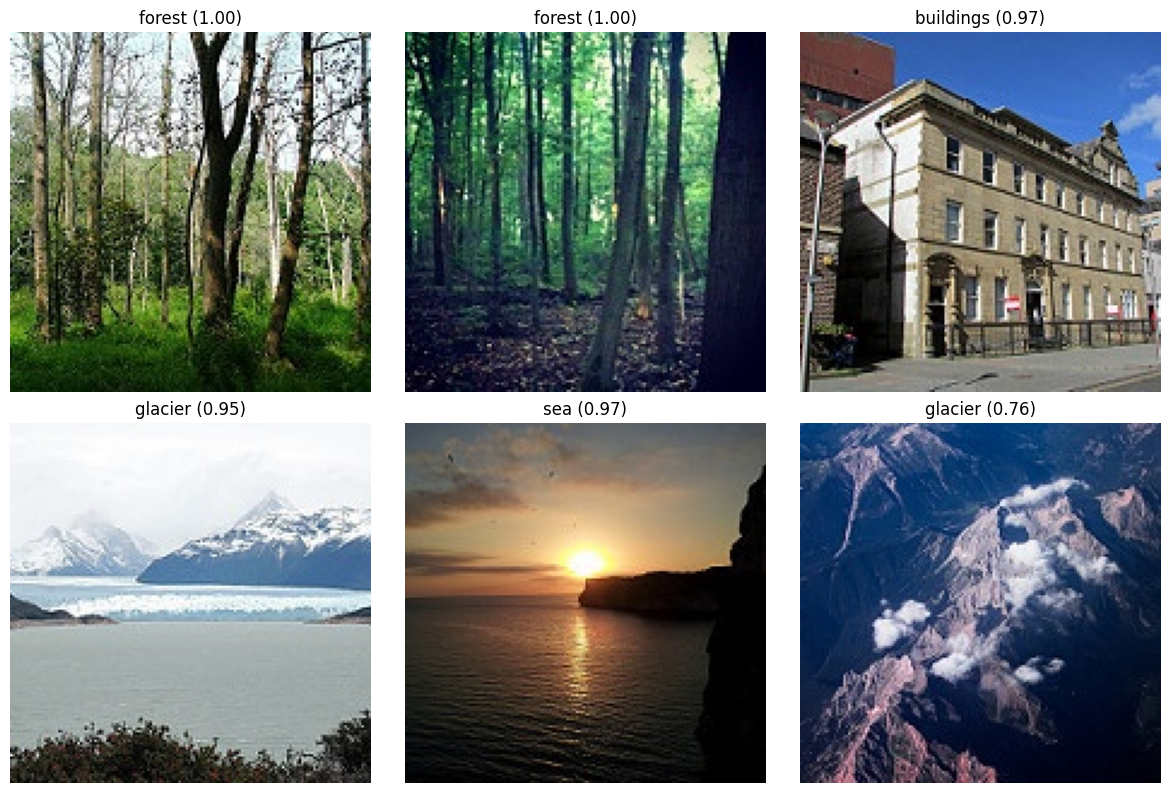

In [12]:
# predict on seg_pred/
import random
from tensorflow.keras.preprocessing import image
from PIL import Image

if os.path.isdir(pred_dir):
    files = [os.path.join(pred_dir, f) for f in os.listdir(pred_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    random.shuffle(files)
    sample = files[:6]
    
    plt.figure(figsize=(12,8))
    for i, p in enumerate(sample):
        img = Image.open(p).convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT))
        arr = np.array(img) / 255.0
        arr_batch = np.expand_dims(arr, axis=0)
        prob = model.predict(arr_batch)[0]
        pred_label = class_labels[np.argmax(prob)]
        plt.subplot(2,3,i+1)
        plt.imshow(img)
        plt.title(f"{pred_label} ({np.max(prob):.2f})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No seg_pred folder found at:", pred_dir)


In [13]:
# save model in native Keras format
model.save("scene_classification_final.keras")
print("Saved to scene_classification_final.keras")


Saved to scene_classification_final.keras
